In [1]:
# Install dependencies.
!rm -r sample_data
!pip install -qq --upgrade transformers compel accelerate diffusers
from IPython.display import clear_output
clear_output()

In [2]:
# Set the details for your model here:
import torch

from diffusers import AutoencoderKL, StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline

use_refiner = True

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    add_watermarker=False
).to("cuda")

if use_refiner:
  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
      vae=vae,
      text_encoder_2=base.text_encoder_2,
      torch_dtype=torch.float16,
      variant="fp16",
      use_safetensors=True,
      add_watermarker=False
  ).to("cuda")
clear_output()

In [3]:
torch.cuda.empty_cache()

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

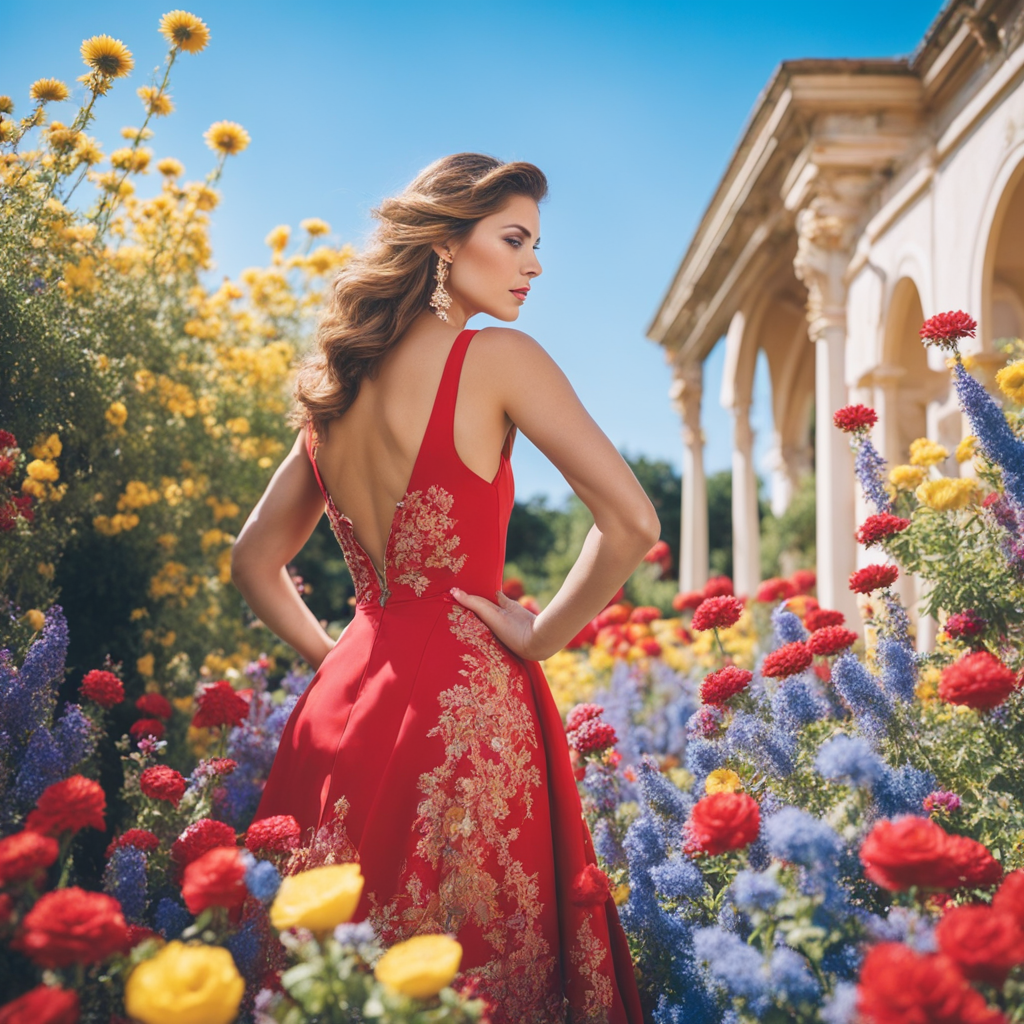

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

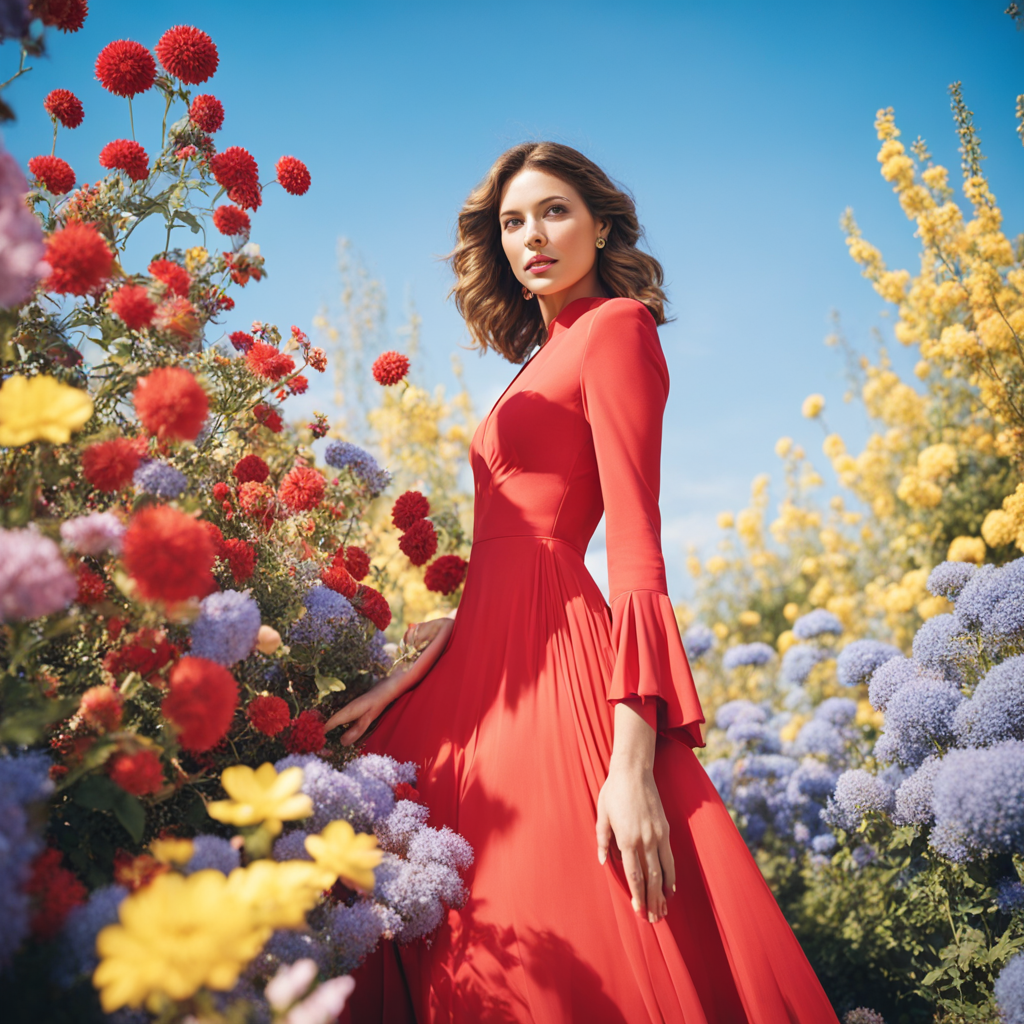

  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [14]:
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt="close up Photograph of woman in red dress in a luxury garden surrounded with blue, yellow, purple and flowers in many colors, high class, award-winning photography, Portra 400, full format"
prompt += "blue sky, intricate details, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic"

num_inference_steps = 30
guidance_scale = 10
maximize_strength = 20
shift_strength = 40
clear_outliers_method = "threshold"

def soft_clamp_tensor(input_tensor, threshold=3.5, boundary=4):
    if max(abs(input_tensor.max()), abs(input_tensor.min())) < 4:
        return input_tensor
    channel_dim = 1

    max_vals = input_tensor.max(channel_dim, keepdim=True)[0]
    max_replace = ((input_tensor - threshold) / (max_vals - threshold)) * (boundary - threshold) + threshold
    over_mask = (input_tensor > threshold)

    min_vals = input_tensor.min(channel_dim, keepdim=True)[0]
    min_replace = ((input_tensor + threshold) / (min_vals + threshold)) * (-boundary + threshold) - threshold
    under_mask = (input_tensor < -threshold)

    return torch.where(over_mask, max_replace, torch.where(under_mask, min_replace, input_tensor))

def clear_outliers(tensor, z_score=4.0, method="mean"):
    axis = (2, 3)

    mean = tensor.mean(axis, keepdim=True).expand_as(tensor)
    std = tensor.std(axis, keepdim=True).expand_as(tensor)

    if method=="mean":
        return torch.where((tensor < mean - z_score * std) | (tensor > mean + z_score * std), mean, tensor)
    elif method=="threshold":
        outliers = torch.abs(tensor - mean) > z_score * std
        shift = z_score * std[outliers]
        tensor[outliers] = torch.where(tensor[outliers] > mean[outliers], mean[outliers] + shift, mean[outliers] - shift)
    return tensor

def normalize_tensor(tensor, boundary):
    min_val = tensor.min()
    max_val = tensor.max()

    normalization_factor = boundary / max(abs(min_val), abs(max_val))

    return tensor * normalization_factor

def center_shift_tensor(tensor, channel_shift=1, full_shift=1, channels=[0, 1, 2, 3]):
    for channel in channels:
        tensor[0, channel] -= tensor[0, channel].mean() * channel_shift
    return tensor - tensor.mean() * full_shift

def callback(pipe, step_index, timestep, cbk):
    boundary = max(abs(cbk["latents"].min()), abs(cbk["latents"].max()))
    cbk["latents"] = clear_outliers(cbk["latents"], method=clear_outliers_method)
    if step_index == 0:
        cbk["latents"] = center_shift_tensor(cbk["latents"])
    elif timestep > 700:
        cbk["latents"] = center_shift_tensor(cbk["latents"], channel_shift=0.008*shift_strength, full_shift=0.01*shift_strength)
    if timestep > 200 and timestep < 300:
        cbk["latents"] = center_shift_tensor(cbk["latents"], channel_shift=0.004*shift_strength, full_shift=0.005*shift_strength, channels=[0, 1, 2])
    if timestep == 1:
        cbk["latents"] = normalize_tensor(cbk["latents"], boundary=boundary+(3.83877-boundary)*maximize_strength/100)
    return cbk

def r(input, w=5):
    return str(round(input.item(),2)).rjust(w)
def callbackz(pipe, step_index, timestep, cbk):
    print("timestep:", r(timestep, 5), "  max:", r(cbk["latents"].max()), "  min:", r(cbk["latents"].min(), 6), "  mean:", r(cbk["latents"].mean()))
    return cbk

for seed in range(1, 10):
  base_seed = seed
  base_generator = torch.Generator()
  base_generator.manual_seed(base_seed)
  if use_refiner:
    refiner_generator = torch.Generator()
    refiner_generator.manual_seed(base_seed ^ 0xffffffff)

  image = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale = guidance_scale, callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=base_generator, denoising_end=0.8 if use_refiner else 1.0, output_type="latent" if use_refiner else "pil").images
  if use_refiner:
    image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=refiner_generator, denoising_start=0.8, image=image).images
  display(image[0])

In [5]:
"""
import os
import time
import diffusers
from diffusers import PNDMScheduler

prompt="Photograph of a beautiful woman standing in a lush garden"
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt += "intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

for use_karras_sigmas in [True]:
    for scheduler in base.scheduler.compatibles:
        scheduler_name = scheduler.__name__
        if scheduler_name in ("PNDMScheduler", "KDPM2AncestralDiscreteScheduler"):
            ske = scheduler.from_config(base.scheduler.config, use_karras_sigmas=use_karras_sigmas)
            base.scheduler = ske
            for num_inference_steps in range(5, 36, 5):
                print("Generating with", scheduler_name)
                start_time = time.time()
                latents = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_end=0.8, output_type="latent").images
                image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_start=0.8, image=latents).images[0]
                folder_path = f"/content/drive/MyDrive/schedulers/{'k' if use_karras_sigmas else ''}{num_inference_steps}"
                os.makedirs(folder_path, exist_ok=True)
                image.save(f"{folder_path}/{str(round(float(time.time()-start_time),2)).replace('.', ',')}_{scheduler_name}.png")
"""

'\nimport os\nimport time\nimport diffusers\nfrom diffusers import PNDMScheduler\n\nprompt="Photograph of a beautiful woman standing in a lush garden"\nnegative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"\nprompt += "intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"\n\nfor use_karras_sigmas in [True]:\n    for scheduler in base.scheduler.compatibles:\n        scheduler_name = scheduler.__name__\n        if scheduler_name in ("PNDMScheduler", "KDPM2AncestralDiscr

In [6]:
!zip -r png_files.zip *.png
!rm -r *.png

	zip warning: name not matched: *.png

zip error: Nothing to do! (try: zip -r png_files.zip . -i *.png)
rm: cannot remove '*.png': No such file or directory
